# Part 1: SIFT-BoVW-SVM

### Implementation of SIFT detector and descriptor

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])  
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
torch.manual_seed(0)

### Compute Cluster centres using bag of visual words

In [10]:
def performSift(image):
    sift = cv2.SIFT_create()
    image = np.array(image)
    keypoints = sift.detect(image, None)
    keypoints, descriptors = sift.compute(image, keypoints)
    return descriptors

def histogram_of_features(inpData, kmeans, n_clusters):
    hist = []
    for i in tqdm(range(len(inpData))):
        image, label = inpData[i]
        image = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX). astype(np.uint8)
        image = image.squeeze()
        desc = performSift(image)
        if desc is None:
            hist.append(np.zeros(n_clusters))
            continue
        histogram = np.histogram(kmeans.predict(desc), bins=n_clusters, range=(0, n_clusters))[0]
        hist.append(histogram)
    return np.vstack(hist)

def cluster_features(desc, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(desc)
    return kmeans

### Train a linear SVM for 10 way classification

In [11]:
trainDesc = []
testDesc = []
for images, labels in tqdm(trainloader):
    for image in images:
        image = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        image = image.squeeze()
        desc = performSift(image)
        if desc is not None:
            trainDesc.append(desc)
for images, labels in tqdm(testloader):
    for image in images:
        image = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        image = image.squeeze()
        desc = performSift(image)
        if desc is not None:
            testDesc.append(desc)

100%|██████████| 157/157 [00:07<00:00, 22.17it/s]


In [14]:
numClusters = 3

traink = np.vstack(trainDesc)
print(traink.shape)
kmeans = cluster_features(traink, numClusters)

(469437, 128)


In [15]:
trainHist = histogram_of_features(trainset, kmeans, numClusters)
testHist = histogram_of_features(testset, kmeans, numClusters)
trainLabel = [label for _, label in trainset]
testLabel = [label for _, label in testset]

100%|██████████| 10000/10000 [00:10<00:00, 940.03it/s]


In [16]:
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_model.fit(trainHist, trainLabel)
predicted = svm_model.predict(testHist)
accuracy = accuracy_score(testLabel, predicted, normalize=True)
print(accuracy)

0.2506


### Visualization of classification accuracy with change in number of clusters

In [18]:
clusterNums = [1, 3, 10, 30, 50, 100]
accuracy = []
for numClusters in tqdm(clusterNums):
    kmeans = cluster_features(traink, numClusters)
    trainHist = histogram_of_features(trainset, kmeans, numClusters)
    testHist = histogram_of_features(testset, kmeans, numClusters)
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    svm_model.fit(trainHist, trainLabel)
    predicted = svm_model.predict(testHist)
    accuracy.append(accuracy_score(testLabel, predicted, normalize=True))

100%|██████████| 6/6 [1:54:45<00:00, 1147.61s/it]


Text(0, 0.5, 'Accuracy')

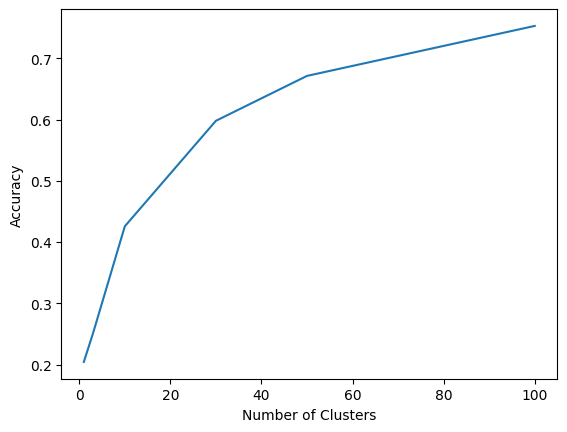

In [19]:
import matplotlib.pyplot as plt
plt.plot(clusterNums, accuracy)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')

In [26]:
for index, acc in enumerate(accuracy):
    print(f'Number of Clusters: {clusterNums[index]}, Accuracy: {acc}')

Number of Clusters: 1, Accuracy: 0.2043
Number of Clusters: 3, Accuracy: 0.2506
Number of Clusters: 10, Accuracy: 0.4257
Number of Clusters: 30, Accuracy: 0.598
Number of Clusters: 50, Accuracy: 0.6713
Number of Clusters: 100, Accuracy: 0.7529


- With the increase in number of clusters, the classification accuracy increases. This is because with the increase in number of clusters, each cluster becomes more specific to certain visual patterns or features within the images. This then enables better discrimination between different classes, as the histogram of visual words capture more detailed information. 
- There is a maximum optimal number of clusters after which the accuracy will stop increasing (cas we can see from the concave down shape of the graph). The accuracy might even start decreasing beyond this optimal number, due to increased complexity and overfitting.
- Among my selection, 100 clusters presents the best accuracy.

### Result Visualization for different hyperparameter settings

In [16]:
def performSiftHyp(image, numFeatures, thresh):
    sift = cv2.SIFT_create(nfeatures=numFeatures, contrastThreshold=thresh)
    image = np.array(image)
    keypoints = sift.detect(image, None)
    keypoints, descriptors = sift.compute(image, keypoints)
    return descriptors

def histogram_of_featuresHyp(inpData, kmeans, n_clusters, numFeatures, thresh):
    hist = []
    for i in tqdm(range(len(inpData))):
        image, label = inpData[i]
        image = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX). astype(np.uint8)
        image = image.squeeze()
        desc = performSiftHyp(image, numFeatures, thresh)
        if desc is None:
            hist.append(np.zeros(n_clusters))
            continue
        histogram = np.histogram(kmeans.predict(desc), bins=n_clusters, range=(0, n_clusters))[0]
        hist.append(histogram)
    return np.vstack(hist)

def cluster_featuresHyp(desc, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(desc)
    return kmeans


def getAccuracy(numClusters, trainset, testset, c, numFeatures, thresh):
    trainDesc = []
    testDesc = []
    for images, labels in tqdm(trainloader):
        for image in images:
            image = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            image = image.squeeze()
            desc = performSiftHyp(image, numFeatures, thresh)
            if desc is not None:
                trainDesc.append(desc)
    for images, labels in tqdm(testloader):
        for image in images:
            image = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            image = image.squeeze()
            desc = performSiftHyp(image, numFeatures, thresh)
            if desc is not None:
                testDesc.append(desc)
    traink = np.vstack(trainDesc)
    kmeans = cluster_featuresHyp(traink, numClusters)
    trainHist = histogram_of_featuresHyp(trainset, kmeans, numClusters, numFeatures, thresh)
    testHist = histogram_of_featuresHyp(testset, kmeans, numClusters, numFeatures, thresh)
    trainLabel = [label for _, label in trainset]
    testLabel = [label for _, label in testset]
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', C=c))
    svm_model.fit(trainHist, trainLabel)
    predicted = svm_model.predict(testHist)
    return accuracy_score(testLabel, predicted, normalize=True)

In [19]:
numClusters = 100
c = 0.1
nFeatures = 100
constThreshold = 0.02
accuracy = getAccuracy(numClusters, trainset, testset, c, nFeatures, constThreshold)
print("For the parameters: numClusters = {}, c = {}, nFeatures = {}, constThreshold = {}, the accuracy is: {}".format(numClusters, c, nFeatures, constThreshold, accuracy))

100%|██████████| 10000/10000 [00:10<00:00, 925.36it/s]


For the parameters: numClusters = 100, c = 0.1, nFeatures = 100, constThreshold = 0.02, the accuracy is: 0.7475


In [20]:
c = 1
nFeatures = 200
constThreshold = 0.04
accuracy = getAccuracy(numClusters, trainset, testset, c, nFeatures, constThreshold)
print("For the parameters: numClusters = {}, c = {}, nFeatures = {}, constThreshold = {}, the accuracy is: {}".format(numClusters, c, nFeatures, constThreshold, accuracy))

100%|██████████| 10000/10000 [00:11<00:00, 899.35it/s]


For the parameters: numClusters = 100, c = 1, nFeatures = 200, constThreshold = 0.04, the accuracy is: 0.7526


In [21]:
c = 10
nFeatures = 300
constThreshold = 0.06
accuracy = getAccuracy(numClusters, trainset, testset, c, nFeatures, constThreshold)
print("For the parameters: numClusters = {}, c = {}, nFeatures = {}, constThreshold = {}, the accuracy is: {}".format(numClusters, c, nFeatures, constThreshold, accuracy))

100%|██████████| 10000/10000 [00:10<00:00, 947.07it/s]


For the parameters: numClusters = 100, c = 10, nFeatures = 300, constThreshold = 0.06, the accuracy is: 0.7521


In [22]:
c = 0.1
nFeatures = 150
constThreshold = 0.03
accuracy = getAccuracy(numClusters, trainset, testset, c, nFeatures, constThreshold)
print("For the parameters: numClusters = {}, c = {}, nFeatures = {}, constThreshold = {}, the accuracy is: {}".format(numClusters, c, nFeatures, constThreshold, accuracy))


100%|██████████| 10000/10000 [00:10<00:00, 960.49it/s]


For the parameters: numClusters = 100, c = 0.1, nFeatures = 150, constThreshold = 0.03, the accuracy is: 0.7499


In [23]:
c = 1
nFeatures = 250
constThreshold = 0.05
accuracy = getAccuracy(numClusters, trainset, testset, c, nFeatures, constThreshold)
print("For the parameters: numClusters = {}, c = {}, nFeatures = {}, constThreshold = {}, the accuracy is: {}".format(numClusters, c, nFeatures, constThreshold, accuracy))

100%|██████████| 10000/10000 [00:10<00:00, 948.97it/s]


For the parameters: numClusters = 100, c = 1, nFeatures = 250, constThreshold = 0.05, the accuracy is: 0.7475


In [24]:
c = 10
nFeatures = 350
constThreshold = 0.07
accuracy = getAccuracy(numClusters, trainset, testset, c, nFeatures, constThreshold)
print("For the parameters: numClusters = {}, c = {}, nFeatures = {}, constThreshold = {}, the accuracy is: {}".format(numClusters, c, nFeatures, constThreshold, accuracy))

100%|██████████| 10000/10000 [00:11<00:00, 901.73it/s]


For the parameters: numClusters = 100, c = 10, nFeatures = 350, constThreshold = 0.07, the accuracy is: 0.756


- With increase in the regularization parameter (C), the accuracy values gradually increase as we can see from our observations. Accuracy values range from approximately 0.7475 to 0.756, indicating that changing C within the given range does not significantly impact classification performance.
- There's a slight variation in accuracy when changing the number of SIFT features. The highest accuracy (0.756) is achieved with a higher number of features (nFeatures = 350), while lower accuracies are observed with fewer features.
- Overall, the observed trends suggest that the choice of SVM regularization parameter (C) and the number of SIFT features (nFeatures) have a relatively modest impact on classification accuracy, while variations in SIFT descriptor parameters (constThreshold) seem to have minimal effect.

# Part 2: CNNs and Transformers

### Use LeNet for performing classification on MNIST

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb

In [ ]:
wandb.init(project="MNIST")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [25]:
class leNet(nn.Module):
    def __init__(self):
        super(leNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [26]:
def dataLoaders(train_dataset, test_dataset, batch_size):
    trainSize = int(0.9 * len(train_dataset))
    valSize = len(train_dataset) - trainSize
    train_dataset, val_dataset = random_split(train_dataset, [trainSize, valSize])
    trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return trainLoader, valLoader, testLoader

In [30]:
def train(model, criterion, optimizer, epochs, trainLoader, valLoader, device):
    
    trainingLosses = []
    validationLosses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainLoader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(i)
            # if i % 400 == 399:
            #     print(f'[{epoch + 1}, {i + 1}] Training loss: {running_loss / 400}')
            #     running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            loss = 0.0
            for data in valLoader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'[{epoch + 1}] Training loss: {running_loss / len(trainLoader)}')
            print(f'[{epoch + 1}] Validation Accuracy: {100 * correct / total}')
            wandb.log({'loss': loss / len(valLoader), 'accuracy': 100 * correct / total})
            print(f'[{epoch + 1}] Validation loss: {loss / len(valLoader)}')
            validationLosses.append(loss / len(valLoader))
            trainingLosses.append(running_loss / len(trainLoader))

    torch.save(model.state_dict(), 'model.pth')
    print('Finished Training')
    return trainingLosses, validationLosses


def test(model, testLoader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        wandb.log({'test_accuracy': 100 * correct / total})
        print('Accuracy of the network on the {} test images: {:.1f}'.format(total, 100 * correct / total))


In [31]:
model = leNet()
model = model.to(device)
# device = torch.device('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
batch_size = 64

In [32]:
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
trainingLoss, validationLoss = train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)

[1] Training loss: 0.27493185139817333
[1] Validation Accuracy: 97.58333333333333
[1] Validation loss: 0.08424770894480195
[2] Training loss: 0.07516877019614582
[2] Validation Accuracy: 97.91666666666667
[2] Validation loss: 0.06981120870369388
[3] Training loss: 0.05413597133214766
[3] Validation Accuracy: 98.16666666666667
[3] Validation loss: 0.058621732364507746
[4] Training loss: 0.041648425441221514
[4] Validation Accuracy: 98.16666666666667
[4] Validation loss: 0.0667716283475029
[5] Training loss: 0.03613792669964056
[5] Validation Accuracy: 98.31666666666666
[5] Validation loss: 0.05257486752135322
[6] Training loss: 0.029230888686974595
[6] Validation Accuracy: 98.55
[6] Validation loss: 0.04678638338141064
[7] Training loss: 0.02618330423639835
[7] Validation Accuracy: 98.7
[7] Validation loss: 0.04834337306501185
[8] Training loss: 0.02077450756945259
[8] Validation Accuracy: 98.66666666666667
[8] Validation loss: 0.04906638457899309
[9] Training loss: 0.019708646185407085

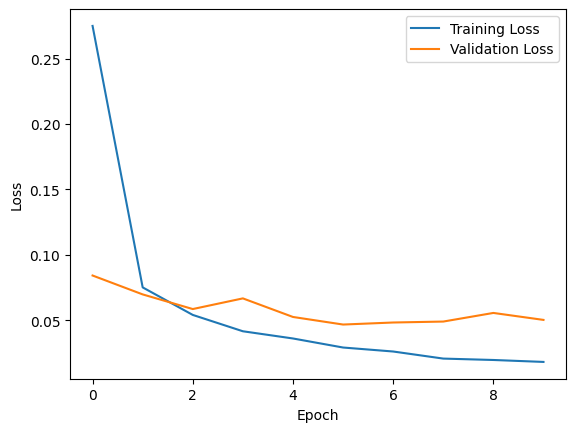

In [33]:
import matplotlib.pyplot as plt
plt.plot(trainingLoss, label='Training Loss')
plt.plot(validationLoss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Visualize results for various hyperparameter settings 

In [34]:
batch_size = 32
lr = 0.0001
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr)
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)

[1] Training loss: 0.010059480877980745
[1] Validation Accuracy: 99.75
[1] Validation loss: 0.008006093293904493
[2] Training loss: 0.006368298794372145
[2] Validation Accuracy: 99.81666666666666
[2] Validation loss: 0.008291937135919745
[3] Training loss: 0.0045336443455921
[3] Validation Accuracy: 99.76666666666667
[3] Validation loss: 0.008307385548443727
[4] Training loss: 0.0035292415351579117
[4] Validation Accuracy: 99.8
[4] Validation loss: 0.009411695943793243
[5] Training loss: 0.0028277333228167193
[5] Validation Accuracy: 99.78333333333333
[5] Validation loss: 0.00857433715595114
[6] Training loss: 0.0021762745548485137
[6] Validation Accuracy: 99.75
[6] Validation loss: 0.01132240623558197
[7] Training loss: 0.001624039630828898
[7] Validation Accuracy: 99.75
[7] Validation loss: 0.009618476274064936
[8] Training loss: 0.0013026447143218917
[8] Validation Accuracy: 99.73333333333333
[8] Validation loss: 0.010569205352773753
[9] Training loss: 0.0011068533626134368
[9] Vali

In [35]:
batch_size = 64
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)

[1] Training loss: 0.007322144390985676
[1] Validation Accuracy: 99.16666666666667
[1] Validation loss: 0.030602307057264664
[2] Training loss: 0.006231511368036748
[2] Validation Accuracy: 99.61666666666666
[2] Validation loss: 0.012628216729044265
[3] Training loss: 0.004182835416182189
[3] Validation Accuracy: 99.76666666666667
[3] Validation loss: 0.00864944054330621
[4] Training loss: 0.003701029500291228
[4] Validation Accuracy: 99.63333333333334
[4] Validation loss: 0.011728889576556384
[5] Training loss: 0.002784419491312395
[5] Validation Accuracy: 99.76666666666667
[5] Validation loss: 0.008480243996833703
[6] Training loss: 0.0015463701531554653
[6] Validation Accuracy: 99.8
[6] Validation loss: 0.009461053768065459
[7] Training loss: 0.0010377883531050337
[7] Validation Accuracy: 99.85
[7] Validation loss: 0.00801270672303705
[8] Training loss: 0.0005316339902588931
[8] Validation Accuracy: 99.88333333333334
[8] Validation loss: 0.006870295750592265
[9] Training loss: 0.000

In [36]:
batch_size = 128
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)

[1] Training loss: 0.009428337525396402
[1] Validation Accuracy: 99.68333333333334
[1] Validation loss: 0.008117626030264334
[2] Training loss: 0.0073185321372360385
[2] Validation Accuracy: 99.3
[2] Validation loss: 0.021925993931832404
[3] Training loss: 0.005838900316914651
[3] Validation Accuracy: 99.45
[3] Validation loss: 0.017236928757957938
[4] Training loss: 0.009828248631059702
[4] Validation Accuracy: 99.58333333333333
[4] Validation loss: 0.012368442235264352
[5] Training loss: 0.004359366406071864
[5] Validation Accuracy: 99.7
[5] Validation loss: 0.00961136930976515
[6] Training loss: 0.006565598693311254
[6] Validation Accuracy: 99.6
[6] Validation loss: 0.012946556965463506
[7] Training loss: 0.005584776523731509
[7] Validation Accuracy: 99.75
[7] Validation loss: 0.009457099502411593
[8] Training loss: 0.004441795915062642
[8] Validation Accuracy: 99.33333333333333
[8] Validation loss: 0.02455222815213811
[9] Training loss: 0.005580191421671139
[9] Validation Accuracy:

In [37]:
batch_size = 64
lr = 0.0001
optimizer = optim.RMSprop(model.parameters(), lr=lr)
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)


[1] Training loss: 0.0018548704160979478
[1] Validation Accuracy: 99.98333333333333
[1] Validation loss: 0.0004584345503718502
[2] Training loss: 0.0006294516433323289
[2] Validation Accuracy: 99.98333333333333
[2] Validation loss: 0.0005469121130170318
[3] Training loss: 0.00027335202181524393
[3] Validation Accuracy: 99.98333333333333
[3] Validation loss: 0.0005508597227082991
[4] Training loss: 0.00014668098978299097
[4] Validation Accuracy: 99.98333333333333
[4] Validation loss: 0.0006774327507044233
[5] Training loss: 8.782699400598406e-05
[5] Validation Accuracy: 99.96666666666667
[5] Validation loss: 0.0005238630351326276
[6] Training loss: 4.755531784539726e-05
[6] Validation Accuracy: 99.96666666666667
[6] Validation loss: 0.001067224011076667
[7] Training loss: 2.185204278161507e-05
[7] Validation Accuracy: 99.98333333333333
[7] Validation loss: 0.0007904488377787238
[8] Training loss: 2.008926119628155e-05
[8] Validation Accuracy: 99.98333333333333
[8] Validation loss: 0.000

In [38]:
batch_size = 32
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)

[1] Training loss: 0.2787163868390508
[1] Validation Accuracy: 94.1
[1] Validation loss: 0.20534059279003836
[2] Training loss: 0.11315503026201126
[2] Validation Accuracy: 97.2
[2] Validation loss: 0.0936748483082796
[3] Training loss: 0.06659987114121728
[3] Validation Accuracy: 98.13333333333334
[3] Validation loss: 0.05724800653564323
[4] Training loss: 0.04937244976342571
[4] Validation Accuracy: 97.91666666666667
[4] Validation loss: 0.07865862154768423
[5] Training loss: 0.04101372938448678
[5] Validation Accuracy: 98.55
[5] Validation loss: 0.055193708434865374
[6] Training loss: 0.037551344413796005
[6] Validation Accuracy: 98.55
[6] Validation loss: 0.05512323975003807
[7] Training loss: 0.032213570556697345
[7] Validation Accuracy: 98.5
[7] Validation loss: 0.05646957797828091
[8] Training loss: 0.027087716128681473
[8] Validation Accuracy: 98.66666666666667
[8] Validation loss: 0.05375227092002767
[9] Training loss: 0.02442239491975019
[9] Validation Accuracy: 98.7333333333

In [39]:
batch_size = 128
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 10
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model, testLoader)

[1] Training loss: 0.015333621001682935
[1] Validation Accuracy: 99.63333333333334
[1] Validation loss: 0.01161792690517688
[2] Training loss: 0.009434876941478678
[2] Validation Accuracy: 99.66666666666667
[2] Validation loss: 0.0118786794659211
[3] Training loss: 0.006211305291264873
[3] Validation Accuracy: 99.53333333333333
[3] Validation loss: 0.013985729745670935
[4] Training loss: 0.0052621198197096665
[4] Validation Accuracy: 99.66666666666667
[4] Validation loss: 0.011535164685889693
[5] Training loss: 0.00682968198292811
[5] Validation Accuracy: 99.36666666666666
[5] Validation loss: 0.02319845313050269
[6] Training loss: 0.005061433625988249
[6] Validation Accuracy: 99.51666666666667
[6] Validation loss: 0.01813293851638322
[7] Training loss: 0.0032777174901434483
[7] Validation Accuracy: 99.56666666666666
[7] Validation loss: 0.015574321479049259
[8] Training loss: 0.0025395643652642336
[8] Validation Accuracy: 99.3
[8] Validation loss: 0.024316813376920418
[9] Training los

- Higher batch sizes (e.g., 128) generally lead to faster convergence and smoother training curves compared to smaller batch sizes (e.g., 32 or 64). In our observations, batch sizes of 32, 64, and 128 all achieve high accuracies, but the convergence patterns and final accuracy levels may vary. However, excessively large batch sizes might cause the model to converge to suboptimal solutions or even diverge due to decreased stochasticity in gradient updates.
- A learning rate that is too low may result in slow convergence, while a learning rate that is too high can lead to unstable training and poor generalization. Learning rates of 0.0001 and 0.001 generally result in smoother training curves and higher final accuracies compared to a learning rate of 0.1, which exhibits more erratic behavior.
- According to our observations, optimizers like Adam and RMSprop tend to converge faster and achieve higher accuracies compared to SGD with momentum.
- Learning rate and optimizer choice have a more significant impact on classification accuracy compared to batch size.
- Models trained with lower learning rates (e.g., 0.0001 or 0.001) using optimizers like Adam or RMSprop tend to achieve higher accuracies and more stable convergence behaviors.

### Compare the best performing CNN against the SIFT-BoVW-SVM approach

- The accuracies obtained by our CNN models is much higher as compared to those obtained through SIFT-BoVW-SVM approach. 
- CNN models automatically learn hierarchical features from raw pixel values through multiple layers of convolutions, pooling, and non-linear activations. They data-driven and capable of learning intricate patterns directly from the images, which can lead to highly discriminative representations for classification tasks. In contrast, the SIFT-BoVW-SVM approach involves a handcrafted feature extraction pipeline. Scale-Invariant Feature Transform (SIFT) features are extracted from images, and then a Bag-of-Visual-Words (BoVW) model is used to represent each image as a histogram of visual words. While SIFT features are robust to variations in scale and rotation, they are less adaptive compared to features learned by CNNs.
- CNNs learn feature representations in an end-to-end manner, optimizing both feature extraction and classification jointly during training. The SIFT-BoVW-SVM approach relies on handcrafted feature descriptors and a predefined pipeline for feature extraction and classification (unable to capture the full complexity).
- CNNs require a large amount of labeled training data and computational resources for training. However, once trained, they can efficiently classify new images. The SIFT-BoVW-SVM approach is computationally expensive during both feature extraction and training. Additionally, the performance of the BoVW model heavily depends on the choice of parameters such as the number of clusters (visual words). As the number of clusters increases, the dimensionality of the feature space grows, which may lead to increased computational complexity and memory requirements. The SIFT-BoVW-SVM approach becomes extremely slow with the increase in number of clusters.

### Change in performance with increase in number of convolution layers

In [54]:
class leNet2(nn.Module):
    def __init__(self):
        super(leNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv12 = nn.Conv2d(6, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv22 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16*1*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv12(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv22(F.relu(self.conv2(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
model2 = leNet2()
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
epochs = 10
batch_size = 64

In [56]:
trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size)
train(model2, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model2, testLoader)

[1] Training loss: 0.3873025266480107
[1] Validation Accuracy: 95.33333333333333
[1] Validation loss: 0.14703472275683221
[2] Training loss: 0.11445595328894695
[2] Validation Accuracy: 97.1
[2] Validation loss: 0.08149114495856648
[3] Training loss: 0.0815191919130816
[3] Validation Accuracy: 97.61666666666666
[3] Validation loss: 0.07671488789306517
[4] Training loss: 0.06426801128336118
[4] Validation Accuracy: 98.11666666666666
[4] Validation loss: 0.05597338118550784
[5] Training loss: 0.055721871849338155
[5] Validation Accuracy: 98.11666666666666
[5] Validation loss: 0.059553718162165516
[6] Training loss: 0.04780875479814076
[6] Validation Accuracy: 98.71666666666667
[6] Validation loss: 0.04263108348761229
[7] Training loss: 0.0426805719493373
[7] Validation Accuracy: 98.56666666666666
[7] Validation loss: 0.04601701566617579
[8] Training loss: 0.03866735669370863
[8] Validation Accuracy: 98.08333333333333
[8] Validation loss: 0.06398343180425148
[9] Training loss: 0.034174581

- Original LeNet:
    - Testing accuracy: 98.8%
    - Final Validation loss: 0.05033082688091684

- Double Convolutional Layers:
    - Testing accuracy: 98.6%
    - Final Validation loss: 0.05909735359966091

- Increasing the number of convolutional layers increases the model's complexity and capacity to learn intricate patterns in the data. However, this increased complexity may not always lead to improved performance. It leads to faster convergence if you have double number of convolutional layers. However, it might be more prone to overfitting as compared to the original model. 

### Change in performance with varying dataset size

In [10]:
def dataLoaders(train_dataset, test_dataset, batch_size, dataLen):
    # trainSize = int(0.9 * len(train_dataset))
    trainSize = int(0.9 * dataLen)
    valSize = dataLen - trainSize
    wasteSize = len(train_dataset) - dataLen
    train_dataset, val_dataset, waste_dataset = random_split(train_dataset, [trainSize, valSize, wasteSize])
    trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return trainLoader, valLoader, testLoader

In [59]:
lenData = [600, 1800, 6000, 18000, 60000]

for dataLen in lenData:
    model = leNet()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f'Length of data: {dataLen}')
    trainLoader, valLoader, testLoader = dataLoaders(train_dataset, test_dataset, batch_size, dataLen)
    train(model, criterion, optimizer, epochs, trainLoader, valLoader, device)
    test(model, testLoader)

Length of data: 600
[1] Training loss: 2.2984461784362793
[1] Validation Accuracy: 16.666666666666668
[1] Validation loss: 2.287897825241089
[2] Training loss: 2.285604821311103
[2] Validation Accuracy: 16.666666666666668
[2] Validation loss: 2.2673768997192383
[3] Training loss: 2.2353653642866345
[3] Validation Accuracy: 33.333333333333336
[3] Validation loss: 2.161525249481201
[4] Training loss: 2.027209851476881
[4] Validation Accuracy: 35.0
[4] Validation loss: 1.8264175653457642
[5] Training loss: 1.6203526258468628
[5] Validation Accuracy: 51.666666666666664
[5] Validation loss: 1.5834287405014038
[6] Training loss: 1.1757380565007527
[6] Validation Accuracy: 56.666666666666664
[6] Validation loss: 1.3060276508331299
[7] Training loss: 0.9148714741071066
[7] Validation Accuracy: 56.666666666666664
[7] Validation loss: 1.0620474815368652
[8] Training loss: 0.7923381659719679
[8] Validation Accuracy: 65.0
[8] Validation loss: 0.8983908295631409
[9] Training loss: 0.715630269712872

- Our accuracy increases from 75% to 99% with increase in the amount of data being used for processing.
- More data provides the model with a better understanding of the underlying patterns in the dataset, leading to higher accuracy.
- When number of sample is 600: The model's performance is relatively low with a small dataset. With limited data, the model struggles to capture the underlying patterns in the dataset, resulting in lower accuracy.
- With a substantial increase in training data to 60,000 samples, we observe the highest accuracy achieved by the model. The abundance of training examples allows the model to capture a wide range of variations in the data, resulting in superior performance.
- With a larger dataset, the model can generalize better to unseen examples. It learns to extract relevant features and patterns that are more representative of the entire dataset, rather than memorizing specific instances from a smaller dataset.

### Train a 2 layer TransformerEncoder and evaluate classification accuracies on varying dataset sizes 

In [30]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class ViT(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(ViT, self).__init__()
        self.patchSize = 7
        self.hidden_dim = hidden_dim
        self.nhead = nhead
        self.num_layers = num_layers
        self.patchDim = self.patchSize**2
        self.patchesNum = (28//self.patchSize)**2
        self.posEmbed = nn.Parameter(torch.randn(1, self.patchesNum + 1, hidden_dim))
        self.projection = nn.Linear(self.patchDim, hidden_dim)
        self.tokens = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        patchSize = self.patchSize
        x = x.unfold(2, patchSize, patchSize).unfold(3, patchSize, patchSize)
        x = x.contiguous().view(batch_size, channels, -1, patchSize, patchSize)
        x = x.permute(0, 2, 3, 4, 1)
        x = x.reshape(batch_size, -1, channels*patchSize*patchSize)
        x = self.projection(x)
        x = torch.cat((self.tokens.expand(batch_size, -1, -1), x), dim=1)
        x += self.posEmbed
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        x = F.relu(self.fc(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x


In [31]:
batch_size = 64
trainSize = int(0.9 * len(trainset))
valSize = len(trainset) - trainSize
train_dataset, val_dataset = random_split(trainset, [trainSize, valSize])
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(testset, batch_size=batch_size, shuffle=True)


In [32]:
inputDim = 16
hiddenDim = 64
outputDim = 10
numLayers = 2
nhead = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = ViT(inputDim, hiddenDim, outputDim, numLayers, nhead)
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

In [33]:
def train(model, criterion, optimizer, epochs, trainLoader, valLoader, device):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainLoader, 0):
            inputs, labels = data
            # inputs = inputs.view(-1, inputDim)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 400 == 399:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')
                running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            loss = 0.0
            for data in valLoader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'[{epoch + 1}] loss: {loss / len(valLoader)}')
        print("Validation Accuracy: ", 100 * correct / total)
    torch.save(model.state_dict(), 'modelTrans.pth')

    print('Finished Training')

def test(model, testLoader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            # images = images.view(-1, inputDim)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the {} test images: {:.1f}'.format(total, 100 * correct / total))

In [34]:
epochs = 10
train(model3, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model3, testLoader)

[1, 400] loss: 0.8403193817138672
[1, 800] loss: 0.7007005299329758
[1] loss: 1.6975333766734346
Validation Accuracy:  77.86666666666666
[2, 400] loss: 0.6722686799764633
[2, 800] loss: 0.6535521035194397
[2] loss: 1.6249218786016424
Validation Accuracy:  84.63333333333334
[3, 400] loss: 0.641171721458435
[3, 800] loss: 0.6354814049005508
[3] loss: 1.5751493281506477
Validation Accuracy:  89.35
[4, 400] loss: 0.6322907426357269
[4, 800] loss: 0.6279182430505753
[4] loss: 1.5621721503582406
Validation Accuracy:  90.15
[5, 400] loss: 0.624608544588089
[5, 800] loss: 0.6230396945476532
[5] loss: 1.553807092473862
Validation Accuracy:  90.96666666666667
[6, 400] loss: 0.6209219110012054
[6, 800] loss: 0.6188151051998139
[6] loss: 1.5495095037399453
Validation Accuracy:  91.31666666666666
[7, 400] loss: 0.6185083919763565
[7, 800] loss: 0.6172711837291718
[7] loss: 1.5374362557492358
Validation Accuracy:  92.7
[8, 400] loss: 0.6153932087421418
[8, 800] loss: 0.614757342338562
[8] loss: 1.54

In [35]:
batch_size = 64
trainSize = 5400
valSize = 600
wasteSize = 54000
train_dataset, val_dataset, waste_dataset = random_split(trainset, [trainSize, valSize, wasteSize])
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [36]:
model3 = ViT(inputDim, hiddenDim, outputDim, numLayers, nhead)
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)
train(model3, criterion, optimizer, epochs, trainLoader, valLoader, device)
test(model3, testLoader)

[1] loss: 2.2811625957489015
Validation Accuracy:  18.0
[2] loss: 2.2101547479629517
Validation Accuracy:  26.833333333333332
[3] loss: 2.070841407775879
Validation Accuracy:  45.0
[4] loss: 1.9706135272979737
Validation Accuracy:  51.333333333333336
[5] loss: 1.8980331659317016
Validation Accuracy:  60.666666666666664
[6] loss: 1.8242630243301392
Validation Accuracy:  70.5
[7] loss: 1.776163387298584
Validation Accuracy:  71.33333333333333
[8] loss: 1.7163463950157165
Validation Accuracy:  79.0
[9] loss: 1.6777763962745667
Validation Accuracy:  79.83333333333333
[10] loss: 1.6806558132171632
Validation Accuracy:  80.16666666666667
Finished Training
Accuracy of the network on the 10000 test images: 80.1


- The ViT model achieves a high validation and test accuracy when trained with 60K samples, surpassing 90% accuracy. This indicates that the model has effectively learned the representations from the large dataset, leading to strong generalization performance.
- With less size of data, VitT is unable to capture the effective representations and generalizations in the data.
- The ViT model trained with 6K samples achieves a lower validation and test accuracy compared to the model trained with 60K samples. While the accuracy is still reasonable, it falls short of the performance achieved with a larger dataset.
- ViT models, with their self-attention mechanism, are known for their ability to capture long-range dependencies and learn representations effectively. However, this effectiveness is highly dependent on the size and diversity of the training data. With a larger dataset, the ViT model can learn more comprehensive representations, leading to higher accuracy.